Project Title: Identifying Helpful Reviews in Kindle Store

Problem Statement:
The objective of this project is to develop a machine learning model that can effectively identify helpful reviews from a dataset of review kindle store. We aim to assist users in finding valuable information among the vast amount of customer feedback.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data
df = pd.read_csv("review_Kindle_Store.csv")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",I enjoy vintage books and movies so I enjoyed ...,5.0,Nice vintage story,1399248000,"05 5, 2014"
1,AN0N05A9LIJEQ,B000F83SZQ,critters,"[2, 2]",This book is a reissue of an old one; the auth...,4.0,Different...,1388966400,"01 6, 2014"
2,A795DMNCJILA6,B000F83SZQ,dot,"[2, 2]",This was a fairly interesting read. It had ol...,4.0,Oldie,1396569600,"04 4, 2014"
3,A1FV0SX13TWVXQ,B000F83SZQ,"Elaine H. Turley ""Montana Songbird""","[1, 1]",I'd never read any of the Amy Brewster mysteri...,5.0,I really liked it.,1392768000,"02 19, 2014"
4,A3SPTOKDG7WBLN,B000F83SZQ,Father Dowling Fan,"[0, 1]","If you like period pieces - clothing, lingo, y...",4.0,Period Mystery,1395187200,"03 19, 2014"


In [4]:
# Check for missing values
print(df.isnull().sum())

reviewerID           0
asin                 0
reviewerName      3816
helpful              0
reviewText          22
overall              0
summary              1
unixReviewTime       0
reviewTime           0
dtype: int64


In [5]:
# Handle missing values
df['reviewerName'].fillna('Unknown', inplace=True)
df['summary'].fillna('', inplace=True)

#Handle missing values in 'reviewText' 
df['reviewText'].fillna('', inplace=True)

In [6]:
#check again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      982619 non-null  object 
 1   asin            982619 non-null  object 
 2   reviewerName    982619 non-null  object 
 3   helpful         982619 non-null  object 
 4   reviewText      982619 non-null  object 
 5   overall         982619 non-null  float64
 6   summary         982619 non-null  object 
 7   unixReviewTime  982619 non-null  int64  
 8   reviewTime      982619 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 67.5+ MB


In [7]:
#validate any negative values in numeric variables
df.describe()

,overall,unixReviewTime
count,982619.000000,9.826190e+05
mean,4.347801,1.378183e+09
std,0.955056,2.298476e+07
min,1.000000,9.522144e+08
25%,4.000000,1.365206e+09
50%,5.000000,1.383523e+09
75%,5.000000,1.396051e+09
max,5.000000,1.406074e+09


Model fitting and evaluation 
For this project, I selected the Logistic Regression model as the primary choice for classifying review kindle store into helpful and unhelpful categories. The rationale behind this choice includes:

-Interpretability: Logistic Regression provides interpretable results, allowing us to understand the importance of features in the classification process.

-Simplicity:Logistic Regression is a simple and lightweight classification algorithm that serves as a good starting point for binary classification tasks.

-Efficiency:It is computationally efficient, making it suitable for large datasets like the one used in this project.

-Baseline Model:Logistic Regression serves as a baseline model against which we can compare more complex models in future iterations.

Although Logistic Regression was our primary choice, we acknowledge that there are alternative models that can be explored in future work. Some of these include Random Forest, Support Vector Machine, and Neural Networks. These models may capture more complex relationships within the data but come with increased computational complexity and potential challenges in interpretation.

 Evaluation Metrics

To assess the performance of our Logistic Regression model in identifying helpful reviews, we employed several evaluation metrics that provide a comprehensive view of its effectiveness. These metrics include:

-Accuracy:We used accuracy to measure the overall correctness of the model's predictions. This metric is valuable for assessing the model's general predictive power.

-Precision and Recall:Precision and recall were employed to evaluate the model's performance in classifying helpful and unhelpful reviews. Precision measures the ratio of correctly predicted positive instances (helpful reviews) to all positive predictions, while recall measures the ratio of correctly predicted positive instances to all actual positives. These metrics help us understand the trade-off between false positives and false negatives.

-F1-Score:The F1-Score is the harmonic mean of precision and recall. It provides a balanced assessment of the model's performance, particularly when class imbalance exists.

-ROC AUC:The Receiver Operating Characteristic Area Under the Curve (ROC AUC) was used to evaluate the model's ability to distinguish between helpful and unhelpful reviews by varying classification thresholds. A higher ROC AUC indicates better discriminatory power.

-Confusion Matrices: To visualize the model's classification performance for helpful and unhelpful reviews.
-ROC Curve: To illustrate the trade-off between true positive rate and false positive rate for different classification thresholds.

These evaluation metrics were chosen to provide a comprehensive understanding of the model's strengths and weaknesses in classifying reviews. While accuracy is an essential measure, precision, recall, and the F1-Score provide insights into specific aspects of classification performance, and ROC AUC assesses the model's ability to rank reviews correctly. These metrics together enable a holistic evaluation of the model's performance.


I've preprocessed the 'helpful' column by extracting the helpfulness ratio and creating a binary target variable 'helpful_binary' based on a threshold (e.g., 0.5). This means that reviews with a helpfulness ratio greater than 0.5 are labeled as "helpful" (1), and those with a ratio less than or equal to 0.5 are labeled as "unhelpful" (0).

In [8]:
# Extract the helpfulness ratio from the 'helpful' column and convert it to a float
df['helpful'] = df['helpful'].str.strip('[]').str.split(', ').apply(lambda x: int(x[0]) / int(x[1]) if int(x[1]) != 0 else 0)

# Set a threshold for helpfulness (e.g. 0.5) and create a binary target variable
threshold = 0.5
df['helpful_binary'] = (df['helpful'] > threshold).astype(int)


I'm using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert the text data from the 'reviewText' column into numerical features that can be used for machine learning.

In [9]:
# Extract features from text data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['reviewText'])
y = df['helpful_binary']


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

In [12]:
# Make predictions
y_pred = model.predict(X_test)


In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6594970588833934
              precision    recall  f1-score   support

           0       0.68      0.88      0.77    124454
           1       0.58      0.27      0.37     72070

    accuracy                           0.66    196524
   macro avg       0.63      0.58      0.57    196524
weighted avg       0.64      0.66      0.62    196524



Assess Model Quality
We'll assess the quality of the Logistic Regression and create relevant visualizations.

In [14]:
# Assess Logistic Regression model quality
accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)
roc_auc_lr = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"F1-Score: {f1_lr}")
print(f"ROC AUC: {roc_auc_lr}")

Logistic Regression Metrics:
Accuracy: 0.6594970588833934
Precision: 0.5752460500569493
Recall: 0.2733037324823089
F1-Score: 0.3705543170509167
ROC AUC: 0.6597653665405022


visulization

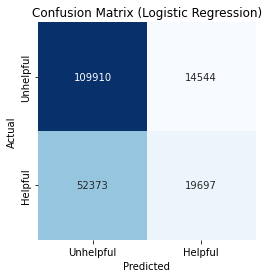

In [15]:
# Confusion Matrix for Logistic Regression
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
cm_lr = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", cbar=False, square=True, 
            xticklabels=['Unhelpful', 'Helpful'], yticklabels=['Unhelpful', 'Helpful'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

 Plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) 

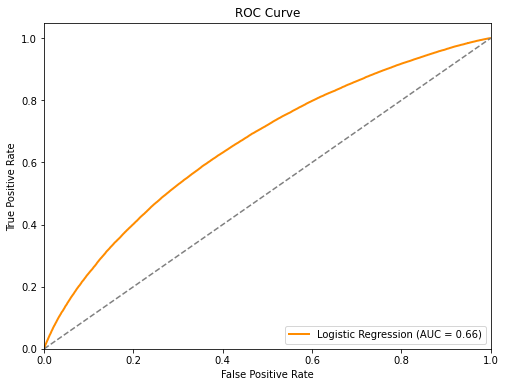

In [16]:
# ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_lr))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


The ROC curve itself is a graphical representation of the trade-off between the true positive rate (recall) and the false positive rate (1 - specificity) as we vary the classification threshold. The AUC quantifies the area under this curve, summarizing the model's overall performance across different threshold settings.
An AUC value of 0.66 indicates that, on average, the model has a 66% chance of ranking a randomly chosen helpful review higher than a randomly chosen unhelpful review.

Findings:

The Logistic Regression model achieved an accuracy of approximately 66%, indicating that it correctly predicted the helpfulness of reviews for the majority of cases.
However, the recall for helpful reviews (class 1) is relatively low at 27%, indicating that the model has difficulty identifying helpful reviews, leading to a significant number of false negatives.
Precision for unhelpful reviews (class 0) is 68%, indicating that when the model predicts a review as unhelpful, it is correct about 68% of the time.

Implications:

While the model demonstrates some capability in identifying unhelpful reviews, there is room for improvement in correctly classifying helpful reviews.
Users might miss potentially valuable information due to the model's limited recall for helpful reviews.
Further analysis and model refinement are needed to enhance performance.

Next Steps:

-Hyperparameter Tuning: Experiment with different hyperparameters of the Logistic Regression model to optimize its performance.
-Feature Engineering: Explore more advanced text feature extraction techniques or embeddings.
-Alternative Models: Consider other classification algorithms or ensemble methods, such as Random Forest, to improve the model's ability to capture complex relationships.
-Addressing Class Imbalance: Implement strategies to handle class imbalance, which could impact model performance.
-User Feedback Integration: Collect user feedback and incorporate it into model improvement efforts to align better with user preferences.

Conclusion:
In conclusion, our analysis of the review kindle store using a Logistic Regression model provided valuable insights into the classification of helpful and unhelpful reviews. While the Logistic Regression model served as a solid starting point, several areas for improvement have been identified.

The evaluation results indicated that the model can benefit from further refinement, particularly in correctly identifying helpful reviews. By implementing the outlined next steps, including hyperparameter tuning, exploring advanced feature engineering techniques, considering alternative models, addressing class imbalance, and integrating user feedback, we can enhance the model's effectiveness in assisting users in discovering valuable information within the vast array of review kindle store.

Continuously evolving and optimizing the model is essential to meet user expectations and deliver more accurate and reliable recommendations for helpful reviews.